# Demag notebook

In [ ]:
# SPDX-FileName: Price forecasting DEMAG.ipynb
# SPDX-FileCopyrightText: Copyright 2010 - 2025 Software GmbH, Darmstadt, Germany and/or its subsidiaries and/or its affiliates
# SPDX-License-Identifier: Apache-2.0

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoLocator, MultipleLocator, MaxNLocator
import pickle
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import sklearn.metrics
import seaborn as sn
import torch
import torch.nn as nn
from torch.optim import Adam
from sklearn.model_selection import KFold
from neuralprophet import NeuralProphet
from fastapi import FastAPI, Query, HTTPException
%matplotlib inline

## Reading Data sources

In [11]:
high_carbon       = pd.read_csv('1.2379 High carbon tool steel.csv')
medium_carbon     = pd.read_csv('C1050 Medium Carbon Steel.csv')
nonalloy_cast     = pd.read_csv('G50CrMo4 Cast non-alloy and low alloy steels.csv')
grey_cast_iron    = pd.read_csv('GG25 Grey cast iron material.csv')
nodular_cast_iron = pd.read_csv('GGG60 Nodularcastiron.csv')
low_carbon        = pd.read_csv('ST37 Low carbon steel.csv')
material_weights  = pd.read_excel('Sheet Metal Stamping Die Materials.xlsx')
higher_copper = pd.read_excel('higher-DEL-Notiz.xlsx')

In [12]:
# Reading exterior possible influencing variables
inflation_df = pd.read_csv("Inflation (CPI).csv")
crude_oil_df = pd.read_csv("Crude oil import prices.csv")
st_interest_rate_df = pd.read_csv("Short-term interest rates.csv")
lt_interest_rate_df = pd.read_csv("Long-term interest rates.csv")
natural_gas = pd.read_csv("Global price of Natural gas.csv")
labor_cost = pd.read_csv("data/labor_cost.csv")
Purchasing_power_parities_df = pd.read_csv("Purchasing power parities.csv")
aluminum_df = pd.read_csv("aluminum120.csv") # https://www.indexmundi.com/commodities/?commodity=aluminum&months=180&currency=eur
electricity = pd.read_csv("energy-charts_Monthly_electricity_spot_market_prices_in_Germany.csv") #https://energy-charts.info/charts/price_average/chart.htm?l=en&c=DE&interval=month&year=-1&timeslider=0
Geschäftslage = pd.read_excel("Geschäftsklima Deutschland.xlsx") #https://www.ifo.de/ifo-zeitreihen
labor_cost_abs = pd.read_excel('DEMAG-labour-costs.xlsx', sheet_name=0) # Interpolated values starting from 2023 labor_cost given from Demag

## Cleaning and exploring Data sources

### Copper

In [8]:
higher_copper.sort_values(by = 'DATE', inplace = True)
higher_copper

,DATE,higher DEL-Notiz
169,2008-01-01,496.05
168,2008-02-01,551.07
167,2008-03-01,558.71
166,2008-04-01,566.35
165,2008-05-01,554.52
...,...,...
4,2021-10-01,853.99
3,2021-11-01,867.10
2,2021-12-01,856.39
1,2022-01-01,878.30


### Labor cost

In [14]:
#labor_cost = labor_cost_abs.iloc[4:,[6,-1]].reset_index(drop= True)
#labor_cost.iloc[0,0] = 'TIME'
#labor_cost.iloc[0,1] = 'labor_cost'
## Retrieve the values of the third row
#new_labels = labor_cost.iloc[0].tolist()
# Assign the new labels to the DataFrame
#labor_cost.columns = new_labels
#labor_cost = labor_cost.iloc[1:,:]
#labor_cost['TIME'] = labor_cost['TIME'].astype(int)
#labor_cost.set_index('TIME', inplace=True)
labor_cost

,ds,y
0,2000-01-01,12.776052
1,2000-02-01,12.776052
2,2000-03-01,12.776052
3,2000-04-01,12.776052
4,2000-05-01,12.776052
...,...,...
272,2022-09-01,23.208056
273,2022-10-01,23.208056
274,2022-11-01,23.208056
275,2022-12-01,23.208056


### Geschäftslage

In [41]:
# Retrieve the values of the third row
new_labels = Geschäftslage.iloc[6].tolist()
# Assign the new labels to the DataFrame
Geschäftslage.columns = new_labels
# crop unnecessary data
Geschäftslage_clean = Geschäftslage[['Monat/Jahr','Geschäftslage']]
Geschäftslage_clean = Geschäftslage_clean.iloc[8:, :2]
# rename column
Geschäftslage_clean.rename(columns={"Monat/Jahr": "date"}, inplace = True)
Geschäftslage_clean['date'] = pd.to_datetime(Geschäftslage_clean['date'])
Geschäftslage_clean['date'] = Geschäftslage_clean['date'].dt.to_period('M')
Geschäftslage_clean

,date,Geschäftslage
8,2005-01,87.4
9,2005-02,87.9
10,2005-03,85.9
11,2005-04,86.4
12,2005-05,86.2
...,...,...
231,2023-08,89
232,2023-09,88.7
233,2023-10,89.2
234,2023-11,89.4


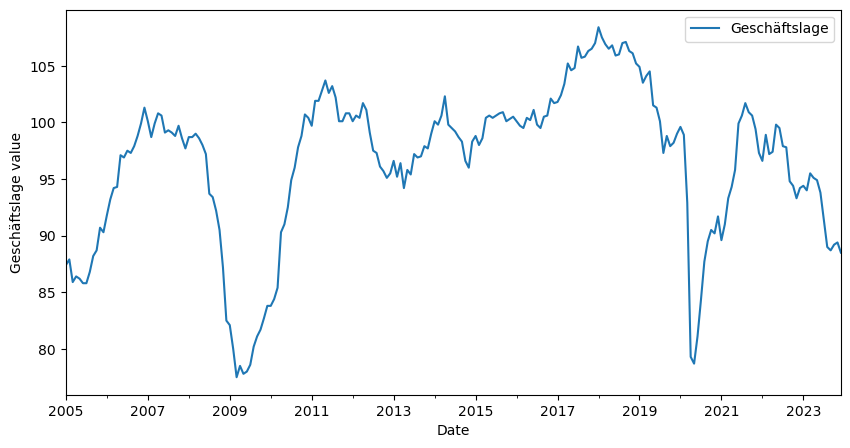

In [143]:
# plot of Geschäftslage
ax = plt.gca()
fig = ax.get_figure()
fig.set_size_inches(10, 5)
Geschäftslage_clean.set_index('date').plot(ax = ax);

ax.set_xlabel('Date')
ax.set_ylabel('Geschäftslage value')

# Show the plot
plt.show()

### Electricity

In [15]:
electricity_clean = electricity.loc[1:]
def convert_to_period(value):
    try:
        month, year = str(value).split('.')
        if len(year) == 3:
            year = year + '0'
        return pd.Period(f"{int(month):2d}-{int(year)}", freq='M')
    except ValueError:
        return pd.NaT

# Apply the custom function to the 'month' column
electricity_clean['Month'] = electricity_clean['Month'].apply(convert_to_period)
electricity_clean.rename(columns={"Day Ahead Auction (volume weighted)": "electricity_price", "Month" : "date"}, inplace = True)
electricity_clean.head(60)

WARNING - (py.warnings._showwarnmsg) - C:\Users\mahmo\AppData\Local\Temp\ipykernel_24452\1893541585.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  electricity_clean['Month'] = electricity_clean['Month'].apply(convert_to_period)

WARNING - (py.warnings._showwarnmsg) - C:\Users\mahmo\AppData\Local\Temp\ipykernel_24452\1893541585.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  electricity_clean.rename(columns={"Day Ahead Auction (volume weighted)": "electricity_price", "Month" : "date"}, inplace = True)



,date,electricity_price
1,2006-01,65.2669
2,2006-02,68.5171
3,2006-03,62.4558
4,2006-04,43.2432
5,2006-05,33.8149
6,2006-06,39.5241
7,2006-07,74.2634
8,2006-08,44.7185
9,2006-09,46.0276
10,2006-10,43.5987


WARNING - (py.warnings._showwarnmsg) - C:\Users\mahmo\AppData\Local\Temp\ipykernel_14364\221311815.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


WARNING - (py.warnings._showwarnmsg) - C:\Users\mahmo\AppData\Local\Temp\ipykernel_14364\221311815.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




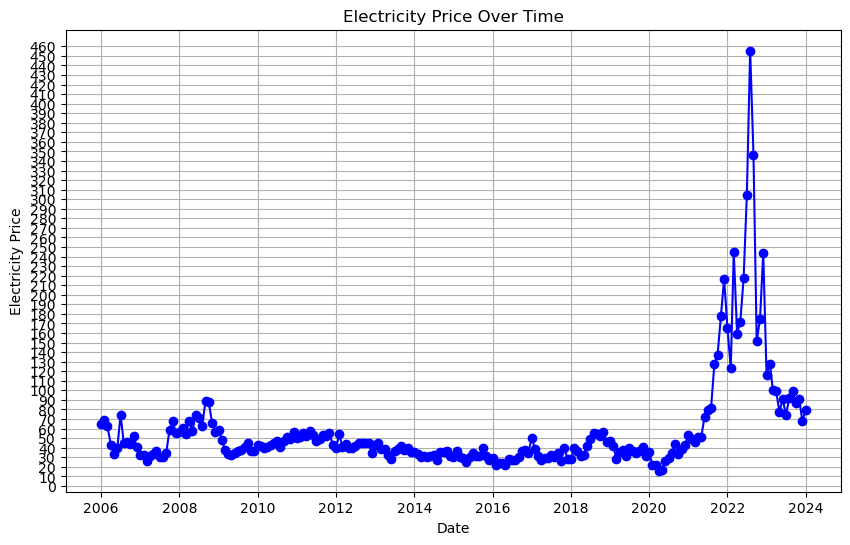

In [144]:
# Assuming 'date' column is not already in datetime format, convert it
electricity_clean['date'] = electricity_clean['date'].dt.to_timestamp()

# Assuming 'electricity_price' is currently formatted as strings, convert it to numeric
electricity_clean['electricity_price'] = pd.to_numeric(electricity_clean['electricity_price'], errors='coerce')

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(electricity_clean['date'], electricity_clean['electricity_price'], marker='o', linestyle='-', color='b')
plt.title('Electricity Price Over Time')
plt.xlabel('Date')
plt.ylabel('Electricity Price')
plt.grid(True)

# Set y-axis ticks with a suitable range
plt.yticks(range(0, int(electricity_clean['electricity_price'].max()) + 10, 10))

plt.show()

### Aluminium

In [16]:
# Retrieve the values of the second row
new_labels = aluminum_df.iloc[0].tolist()

# Assign the new labels to the DataFrame
aluminum_df.columns = new_labels

# remove the first row
aluminum_cleaned = aluminum_df.iloc[1:]
aluminum_cleaned = aluminum_cleaned.reset_index(drop=True)

In [17]:
aluminum_cleaned['Month'] = pd.to_datetime(aluminum_cleaned['Month'], format='%b-%y').dt.strftime('%Y-%m')
aluminum_cleaned = aluminum_cleaned[['Month', 'Price']]
aluminum_cleaned

,Month,Price
0,2003-11,"1,289.28"
1,2003-12,"1,265.87"
2,2004-01,"1,273.77"
3,2004-02,"1,333.03"
4,2004-03,"1,350.62"
...,...,...
236,2023-07,"1,950.30"
237,2023-08,"1,958.63"
238,2023-09,"2,046.06"
239,2023-10,"2,075.19"


In [18]:
aluminum_cleaned.rename(columns={"Price": "alu_value" , "Month": "date"}, inplace = True)
aluminum_cleaned

,date,alu_value
0,2003-11,"1,289.28"
1,2003-12,"1,265.87"
2,2004-01,"1,273.77"
3,2004-02,"1,333.03"
4,2004-03,"1,350.62"
...,...,...
236,2023-07,"1,950.30"
237,2023-08,"1,958.63"
238,2023-09,"2,046.06"
239,2023-10,"2,075.19"


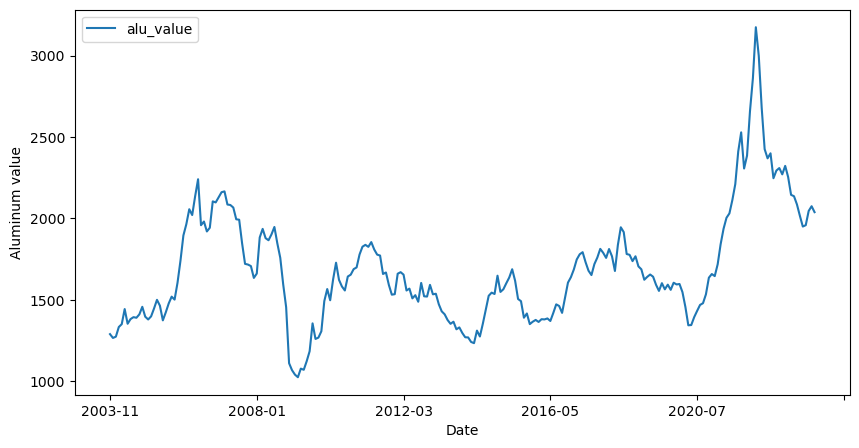

In [19]:
# plot of alu
ax = plt.gca()
fig = ax.get_figure()
fig.set_size_inches(10, 5)
aluminum_cleaned['alu_value'] = pd.to_numeric(aluminum_cleaned['alu_value'].str.replace(',', ''), errors='coerce')
aluminum_cleaned.set_index('date').plot(ax = ax);

ax.set_xlabel('Date')
ax.set_ylabel('Aluminum value')

# Show the plot
plt.show()

### Combining financial data (inflation	st_interest	lt_interest	PPP)

In [20]:
inflation_df = inflation_df.groupby(['TIME']).mean().rename(columns={'Value':'inflation'})
crude_oil_df = crude_oil_df.groupby(['TIME']).mean().rename(columns={'Value':'crude_oil'})
st_interest_rate_df = st_interest_rate_df.groupby(['TIME']).mean().rename(columns={'Value':'st_interest'})
lt_interest_rate_df = lt_interest_rate_df.groupby(['TIME']).mean().rename(columns={'Value':'lt_interest'})
#labor_costs = labor_costs.groupby(['TIME']).mean().rename(columns={'Value':'labor_cost'})
ppp = Purchasing_power_parities_df.groupby(['TIME']).mean().rename(columns={'Value':'PPP'})

WARNING - (py.warnings._showwarnmsg) - C:\Users\mahmo\AppData\Local\Temp\ipykernel_24452\3447988446.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  inflation_df = inflation_df.groupby(['TIME']).mean().rename(columns={'Value':'inflation'})

WARNING - (py.warnings._showwarnmsg) - C:\Users\mahmo\AppData\Local\Temp\ipykernel_24452\3447988446.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  crude_oil_df = crude_oil_df.groupby(['TIME']).mean().rename(columns={'Value':'crude_oil'})

WARNING - (py.warnings._showwarnmsg) - C:\Users\mahmo\AppData\Local\Temp\ipykernel_24452\3447988446.py:3: FutureWarning: The d

In [21]:
inflation_df.drop(['Flag Codes'], axis=1, inplace = True)
st_interest_rate_df.drop(['Flag Codes'], axis=1, inplace = True)
lt_interest_rate_df.drop(['Flag Codes'], axis=1, inplace = True)
ppp.drop(['Flag Codes'], axis=1, inplace = True)
#labor_costs.drop(['Flag Codes'], axis=1, inplace = True)

In [23]:
financial_data = pd.merge(inflation_df, st_interest_rate_df, on='TIME', how = 'left')
financial_data = pd.merge(financial_data, lt_interest_rate_df, on='TIME')
financial_data = pd.merge(financial_data, ppp, on='TIME')
#financial_data = pd.merge(financial_data, labor_cost, on='TIME')
financial_data = financial_data.reset_index().rename(columns={'TIME': 'date'})

In [24]:
financial_data

,date,inflation,st_interest,lt_interest,PPP
0,2000,3.710226,NaN,5.543934,0.740730
1,2001,3.672816,4.764819,5.623570,0.745609
2,2002,2.793854,3.924867,5.180400,0.742148
3,2003,2.598347,2.921931,4.416011,0.751083
4,2004,2.683886,2.546626,4.210969,0.751177
5,2005,2.670570,2.386524,3.432316,0.754784
6,2006,2.888205,3.240790,3.881354,0.740847
7,2007,3.359539,4.586468,4.441220,0.745319
8,2008,5.111056,4.968100,4.648904,0.736893
9,2009,0.539673,2.472454,5.293950,0.722689


### Energy Costs  (Gas and Crude oil)

In [28]:
gas_dates = natural_gas['DATE'].values
gas_prices = natural_gas['PNGASEUUSDM'].values
# preprocessing Gas data
count = 0
gas_sum = 0
avg_count = 0
gas_map = {}
while count < len(gas_dates) - 1:
    if gas_dates[count][0:4] == gas_dates[count + 1][0:4]:
        gas_sum += gas_prices[count]
        avg_count += 1
    else:
        gas_sum += gas_prices[count]
        average = gas_sum / avg_count + 1
        gas_map[gas_dates[count][0:4]] = average
        gas_sum = 0
        avg_count = 0
    count += 1
    
print(gas_map)

{'2001': 5.225324675324675, '2002': 3.9087288469106647, '2003': 4.803265993265993, '2004': 5.096363636363637, '2005': 7.452727272727272, '2006': 9.95909090909091, '2007': 9.882727272727273, '2008': 15.331818181818182, '2009': 10.660000000000004, '2010': 9.97, '2011': 12.56, '2012': 14.069999999999999, '2013': 13.206363636363637, '2014': 12.414545454545456, '2015': 8.969090909090909, '2016': 5.749090909090909, '2017': 7.266237815927383, '2018': 9.635738759720663, '2019': 5.859844546214164, '2020': 4.467159799476441, '2021': 18.35348732976587}


In [29]:
count = 0
while count < len(gas_dates) - 1:
    if gas_dates[count][0:4] == gas_dates[count + 1][0:4]:
        gas_sum += gas_prices[count]
        avg_count += 1
    else:
        gas_sum += gas_prices[count]
        average = gas_sum / avg_count + 1
        gas_map[gas_dates[count][0:4]] = average
        gas_sum = 0
        avg_count = 0
    count += 1

In [30]:
gas_prices = pd.DataFrame.from_dict(gas_map, orient='index', columns = ['gas_price'])
gas_prices.index.name = 'TIME'
gas_prices.index = gas_prices.index.astype('int64')
crude_oil_df = crude_oil_df.groupby(['TIME']).mean().rename(columns={'Value':'crude_oil'})

In [31]:
energy_cost = pd.merge(gas_prices, crude_oil_df, on = 'TIME')
energy_cost

,gas_price,crude_oil
TIME,,
2001,5.225325,24.046364
2002,3.908729,24.425455
2003,4.803266,28.388182
2004,5.096364,36.656364
2005,7.452727,51.704545
2006,9.959091,62.811818
2007,9.882727,70.700000
2008,15.331818,96.742500
2009,10.660000,60.989167


In [32]:
energy_cost['gas_price'].corr(energy_cost['crude_oil'])

0.8113039079159269

In [33]:
# processing energy features and transforming into monthly frequency
energy_cost = energy_cost.reset_index().rename(columns={'TIME': 'date'})
energy_cost['date'] = pd.to_datetime(energy_cost['date'], format='%Y')
energy_cost_monthly = energy_cost.set_index('date').resample('M').ffill().reset_index()
energy_cost_monthly['date'] = energy_cost_monthly['date'].dt.to_period('M')
energy_cost_monthly

,date,gas_price,crude_oil
0,2001-01,5.225325,24.046364
1,2001-02,5.225325,24.046364
2,2001-03,5.225325,24.046364
3,2001-04,5.225325,24.046364
4,2001-05,5.225325,24.046364
...,...,...,...
236,2020-09,4.467160,42.438462
237,2020-10,4.467160,42.438462
238,2020-11,4.467160,42.438462
239,2020-12,4.467160,42.438462


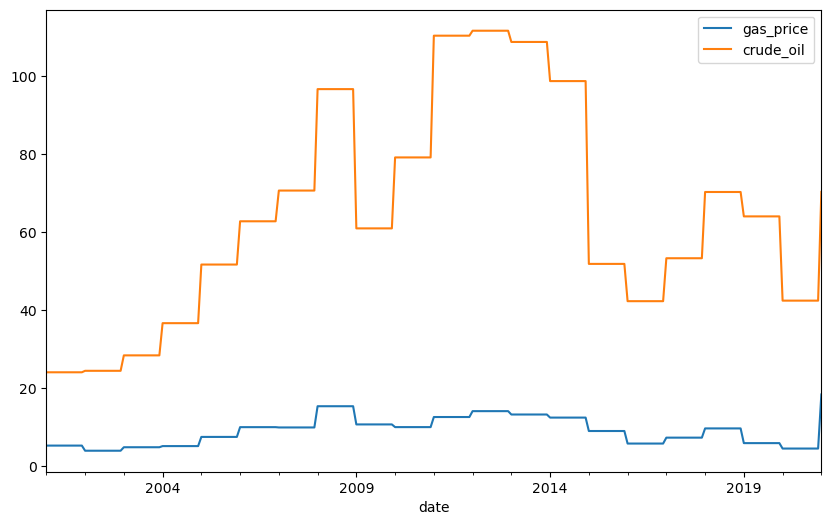

In [34]:
# plot energy data
ax = plt.gca()
fig = ax.get_figure()
fig.set_size_inches(10, 6)

energy_cost_monthly.set_index('date').plot(ax = ax);
# Show the plot
plt.show()

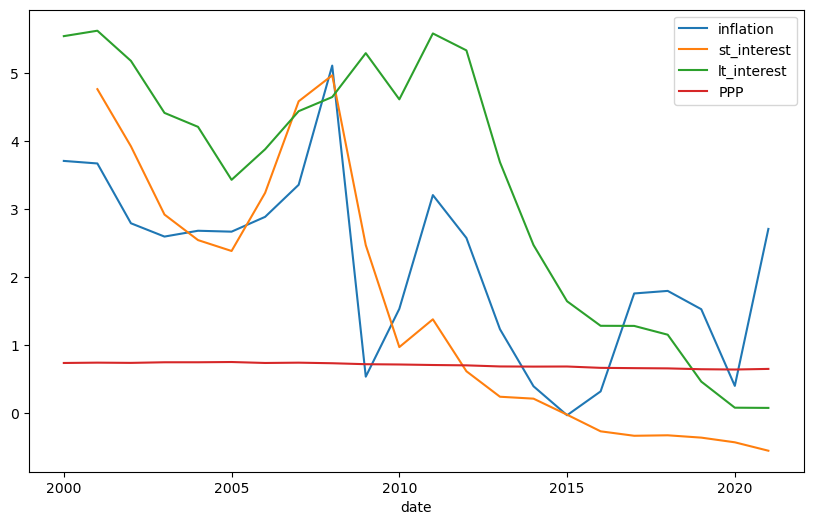

In [35]:
# plot of original metal price trends
ax = plt.gca()
fig = ax.get_figure()
fig.set_size_inches(10, 6)

financial_data.set_index('date').plot(ax = ax);

# Show the plot
plt.show()

In [36]:
financial_data

,date,inflation,st_interest,lt_interest,PPP
0,2000,3.710226,NaN,5.543934,0.740730
1,2001,3.672816,4.764819,5.623570,0.745609
2,2002,2.793854,3.924867,5.180400,0.742148
3,2003,2.598347,2.921931,4.416011,0.751083
4,2004,2.683886,2.546626,4.210969,0.751177
5,2005,2.670570,2.386524,3.432316,0.754784
6,2006,2.888205,3.240790,3.881354,0.740847
7,2007,3.359539,4.586468,4.441220,0.745319
8,2008,5.111056,4.968100,4.648904,0.736893
9,2009,0.539673,2.472454,5.293950,0.722689


In [37]:
aluminum_cleaned['date'] = pd.to_datetime(aluminum_cleaned['date'])
financial_data['date'] = pd.to_datetime(financial_data['date'], format='%Y')
financial_data = financial_data.set_index('date').resample('M').ffill().reset_index()
financial_data

,date,inflation,st_interest,lt_interest,PPP
0,2000-01-31,3.710226,NaN,5.543934,0.740730
1,2000-02-29,3.710226,NaN,5.543934,0.740730
2,2000-03-31,3.710226,NaN,5.543934,0.740730
3,2000-04-30,3.710226,NaN,5.543934,0.740730
4,2000-05-31,3.710226,NaN,5.543934,0.740730
...,...,...,...,...,...
248,2020-09-30,0.404157,-0.425150,0.083638,0.644620
249,2020-10-31,0.404157,-0.425150,0.083638,0.644620
250,2020-11-30,0.404157,-0.425150,0.083638,0.644620
251,2020-12-31,0.404157,-0.425150,0.083638,0.644620


In [38]:
financial_data['date'] = financial_data['date'].dt.to_period('M')
aluminum_cleaned['date'] = aluminum_cleaned['date'].dt.to_period('M')
financial_data

,date,inflation,st_interest,lt_interest,PPP
0,2000-01,3.710226,NaN,5.543934,0.740730
1,2000-02,3.710226,NaN,5.543934,0.740730
2,2000-03,3.710226,NaN,5.543934,0.740730
3,2000-04,3.710226,NaN,5.543934,0.740730
4,2000-05,3.710226,NaN,5.543934,0.740730
...,...,...,...,...,...
248,2020-09,0.404157,-0.425150,0.083638,0.644620
249,2020-10,0.404157,-0.425150,0.083638,0.644620
250,2020-11,0.404157,-0.425150,0.083638,0.644620
251,2020-12,0.404157,-0.425150,0.083638,0.644620


In [39]:
joined_data = pd.merge(financial_data, aluminum_cleaned, on='date', how = 'outer')
joined_data

,date,inflation,st_interest,lt_interest,PPP,alu_value
0,2000-01,3.710226,NaN,5.543934,0.74073,NaN
1,2000-02,3.710226,NaN,5.543934,0.74073,NaN
2,2000-03,3.710226,NaN,5.543934,0.74073,NaN
3,2000-04,3.710226,NaN,5.543934,0.74073,NaN
4,2000-05,3.710226,NaN,5.543934,0.74073,NaN
...,...,...,...,...,...,...
282,2023-07,NaN,NaN,NaN,NaN,1950.30
283,2023-08,NaN,NaN,NaN,NaN,1958.63
284,2023-09,NaN,NaN,NaN,NaN,2046.06
285,2023-10,NaN,NaN,NaN,NaN,2075.19


In [42]:
joined_data = pd.merge(joined_data, Geschäftslage_clean, on='date', how = 'right')

In [44]:
joined_data = pd.merge(joined_data, electricity_clean, on='date', how = 'right')

In [45]:
joined_data = pd.merge(joined_data, energy_cost_monthly, on='date', how = 'left')

In [46]:
# Convert 'DATE' column to datetime type
joined_data['date'] = pd.to_datetime(joined_data['date'].astype(str), format='%Y-%m')
# Extract year, month, and day as separate features
joined_data['Year'] = joined_data['date'].dt.year
joined_data['Month'] = joined_data['date'].dt.month

In [47]:
joined_data = joined_data.query('Year <= 2020 and Year >= 2004').reset_index(drop = True)

In [48]:
joined_data.isna().sum()

date                 0
inflation            0
st_interest          0
lt_interest          0
PPP                  0
alu_value            0
Geschäftslage        0
electricity_price    0
gas_price            0
crude_oil            0
Year                 0
Month                0
dtype: int64

In [49]:
joined_data

,date,inflation,st_interest,lt_interest,PPP,alu_value,Geschäftslage,electricity_price,gas_price,crude_oil,Year,Month
0,2006-01-01,2.888205,3.24079,3.881354,0.740847,1964.83,91.8,65.2669,9.959091,62.811818,2006,1
1,2006-02-01,2.888205,3.24079,3.881354,0.740847,2056.74,93.2,68.5171,9.959091,62.811818,2006,2
2,2006-03-01,2.888205,3.24079,3.881354,0.740847,2021.01,94.2,62.4558,9.959091,62.811818,2006,3
3,2006-04-01,2.888205,3.24079,3.881354,0.740847,2136.25,94.3,43.2432,9.959091,62.811818,2006,4
4,2006-05-01,2.888205,3.24079,3.881354,0.740847,2240.95,97.1,33.8149,9.959091,62.811818,2006,5
...,...,...,...,...,...,...,...,...,...,...,...,...
175,2020-08-01,0.404157,-0.42515,0.083638,0.644620,1468.79,87.7,34.5799,4.467160,42.438462,2020,8
176,2020-09-01,0.404157,-0.42515,0.083638,0.644620,1479.32,89.5,43.6161,4.467160,42.438462,2020,9
177,2020-10-01,0.404157,-0.42515,0.083638,0.644620,1533.99,90.5,33.568,4.467160,42.438462,2020,10
178,2020-11-01,0.404157,-0.42515,0.083638,0.644620,1635.95,90.2,38.5392,4.467160,42.438462,2020,11


In [50]:
#interpolating for missing values
columns_to_interpolate = joined_data.columns.difference(['date','Year','Month'])

for column in columns_to_interpolate:
    joined_data[column].interpolate(method='linear',inplace = True)

WARNING - (py.warnings._showwarnmsg) - C:\Users\mahmo\AppData\Local\Temp\ipykernel_24452\644177126.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sn.heatmap(joined_data[joined_data.columns.difference(['Year','Month'])].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)



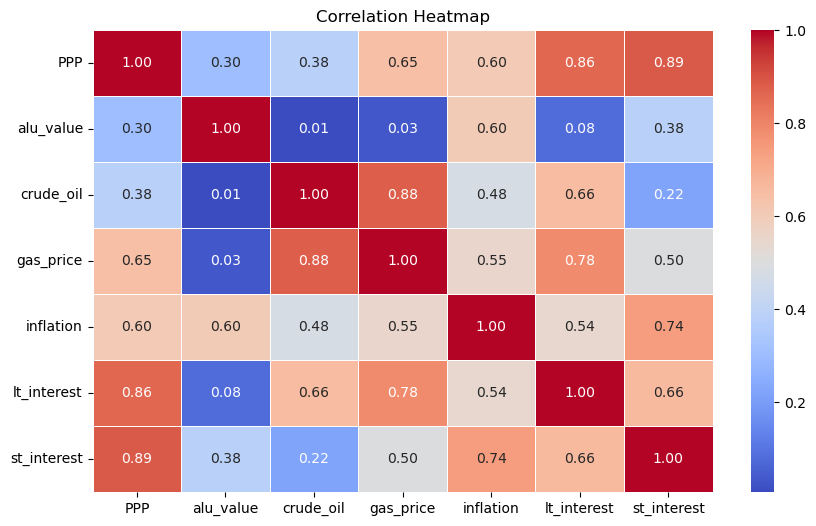

In [51]:
plt.figure(figsize=(10, 6))
sn.heatmap(joined_data[joined_data.columns.difference(['Year','Month'])].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [52]:
#gas price and crude oil are highly correlated, so we can remove one of them
joined_data = joined_data.drop('gas_price', axis=1)

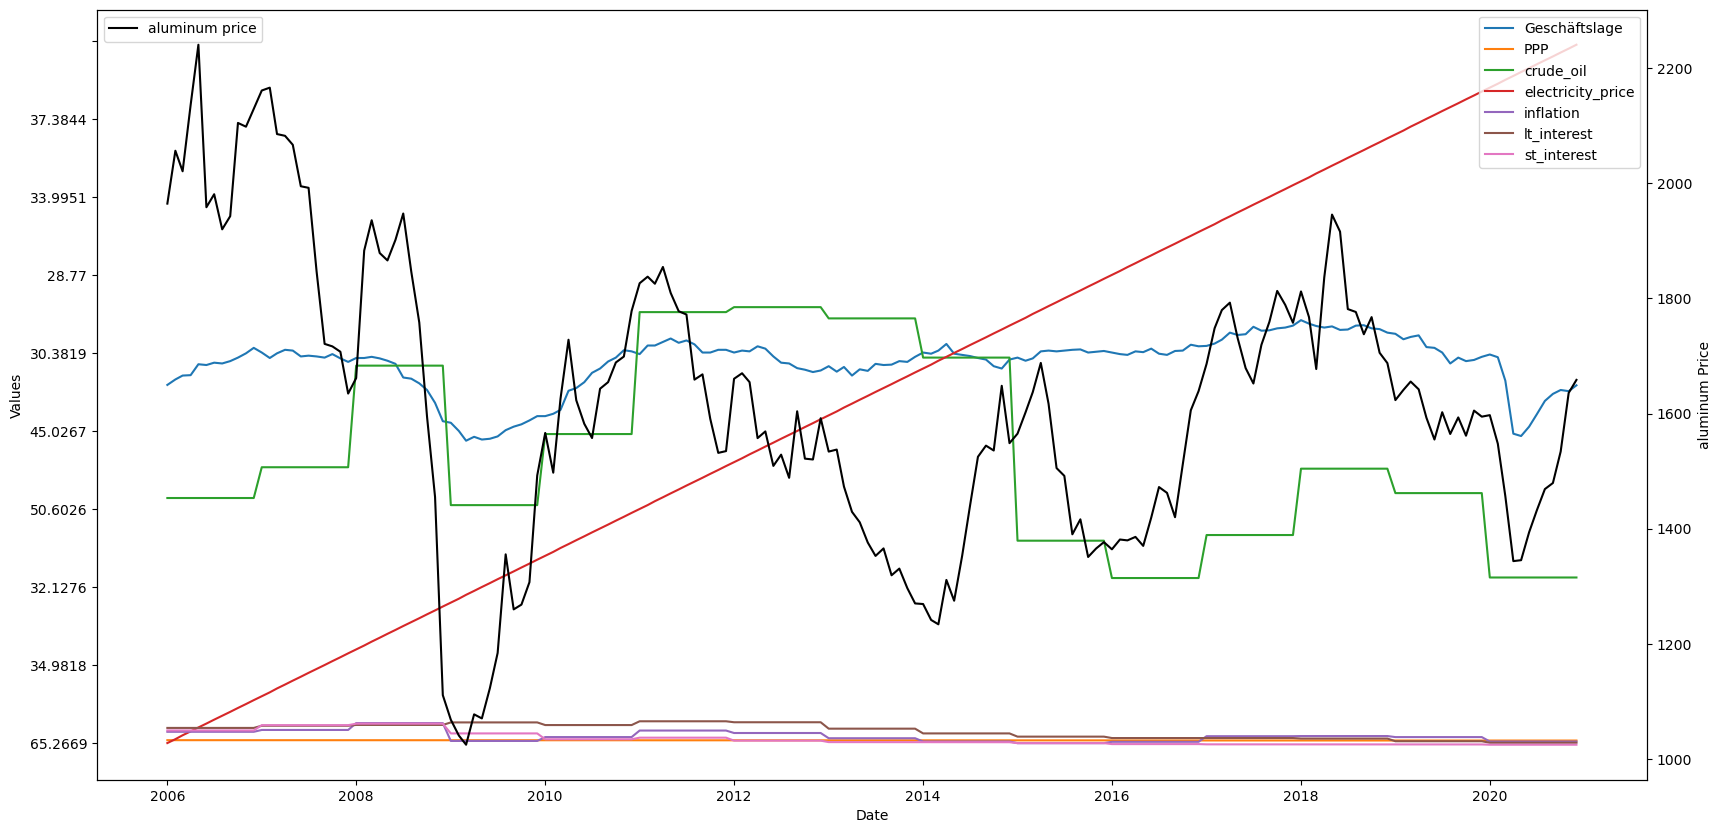

In [53]:
# Creating the figure and axes
fig, ax1 = plt.subplots()
fig.set_size_inches(20, 10)

# Plotting the first y-axis (other columns except 'accumulated_price')
columns_to_plot = joined_data.columns.difference(['date', 'Year', 'Month','alu_value'])
for column in columns_to_plot:
    ax1.plot(joined_data['date'], joined_data[column], label=column)

# Setting labels and legends for the first y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Values')
ax1.legend(loc='upper right')

# Adjusting the layout of the left y-axis ticks
ax1.yaxis.set_major_locator(MaxNLocator(prune='both'))
#ax1.tick_params(axis='y', labelrotation=45)  # Rotate tick labels for better readability

# Creating the second y-axis for 'accumulated_price'
ax2 = ax1.twinx()
ax2.plot(joined_data['date'], joined_data['alu_value'], color='black', label='aluminum price')
ax2.set_ylabel('aluminum Price')
ax2.legend(loc='upper left')

# Displaying the plot
plt.show()

## Prediction Models

### Linear Regression (Baseline)

In [54]:
# Drop the original 'DATE' column
joined_data = joined_data.drop('date', axis=1)

In [55]:
from sklearn.model_selection import train_test_split
# Splitting into features (X) and target (y)
X = joined_data.drop('alu_value', axis=1).values  # Features (all columns except 'accumulated_price')
y = joined_data['alu_value'].values  # Target variable
# Splitting into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [56]:
from sklearn.linear_model import LinearRegression

# Create an instance of the Linear Regression model
model = LinearRegression()

# Train the model using the training data
model.fit(X_train, y_train)

LinearRegression()

In [57]:
from sklearn.metrics import mean_squared_error
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 16769.23436916218


## Deep learning models

### LSTM

In [58]:
joined_data

,inflation,st_interest,lt_interest,PPP,alu_value,Geschäftslage,electricity_price,crude_oil,Year,Month
0,2.888205,3.24079,3.881354,0.740847,1964.83,91.8,65.2669,62.811818,2006,1
1,2.888205,3.24079,3.881354,0.740847,2056.74,93.2,68.5171,62.811818,2006,2
2,2.888205,3.24079,3.881354,0.740847,2021.01,94.2,62.4558,62.811818,2006,3
3,2.888205,3.24079,3.881354,0.740847,2136.25,94.3,43.2432,62.811818,2006,4
4,2.888205,3.24079,3.881354,0.740847,2240.95,97.1,33.8149,62.811818,2006,5
...,...,...,...,...,...,...,...,...,...,...
175,0.404157,-0.42515,0.083638,0.644620,1468.79,87.7,34.5799,42.438462,2020,8
176,0.404157,-0.42515,0.083638,0.644620,1479.32,89.5,43.6161,42.438462,2020,9
177,0.404157,-0.42515,0.083638,0.644620,1533.99,90.5,33.568,42.438462,2020,10
178,0.404157,-0.42515,0.083638,0.644620,1635.95,90.2,38.5392,42.438462,2020,11


In [59]:
#splitting data to training and testing sets
train_size = int(len(joined_data) * 0.8)
train_data, test_data = joined_data[:train_size], joined_data[train_size:]

In [60]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        y_pred = self.linear(lstm_out[:, -1, :])
        return y_pred

In [61]:
# Create sequences for training
def create_sequences(dataset, look_back):
    data_X, data_Y = [], []
    for i in range(len(dataset) - look_back):
        data_X.append(dataset[i:(i + look_back), :])
        data_Y.append(dataset[i + look_back, -1])  # Target column is the last one in the sequence
    return np.array(data_X), np.array(data_Y)

In [62]:
def train_lstm_model_with_early_stopping(df, target_column='alu_value', look_back=1, num_epochs=100, batch_size=32, lr=0.001, n_splits=5, patience=10):
    """
    Train an LSTM model for timeseries forecasting using PyTorch with early stopping using k-fold cross-validation.

    Parameters:
        df (pandas.DataFrame): The input dataframe containing the timeseries data.
        target_column (str): The column to forecast.
        look_back (int): Number of previous time steps to use as input for each prediction.
        num_epochs (int): Maximum number of training epochs per fold.
        batch_size (int): Batch size for training.
        lr (float): Learning rate for the optimizer.
        n_splits (int): Number of splits for k-fold cross-validation.
        patience (int): Number of epochs with no improvement to wait before early stopping.

    Returns:
        model (LSTMModel): The trained LSTM model.
        scaler (sklearn.preprocessing.MinMaxScaler): The MinMaxScaler used for normalization.
    """
    # Extract the target column and the features for training
    target_data = df[target_column].values.reshape(-1, 1)
    feature_data = df.drop(columns=[target_column]).values

    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    target_data = scaler.fit_transform(target_data)
    feature_data = scaler.fit_transform(feature_data)

    # Combine features and target into one array
    data = np.hstack((feature_data, target_data))
    train_X, train_Y = create_sequences(data, look_back)

    # Convert numpy arrays to PyTorch tensors
    train_X = torch.tensor(train_X, dtype=torch.float32)
    train_Y = torch.tensor(train_Y, dtype=torch.float32).view(-1, 1)

    # Perform k-fold cross-validation with early stopping
    kf = KFold(n_splits=n_splits, shuffle=True)

    best_model = None
    best_loss = float('inf')
    no_improvement_count = 0

    for fold, (train_index, val_index) in enumerate(kf.split(train_X)):
        print(f"Training on Fold {fold + 1}/{n_splits}")

        # Split data into training and validation sets for this fold
        X_train_fold, X_val_fold = train_X[train_index], train_X[val_index]
        y_train_fold, y_val_fold = train_Y[train_index], train_Y[val_index]

        input_size = X_train_fold.shape[2]
        hidden_size = 50
        output_size = 1
        # Create a new instance of the LSTM model for each fold
        model = LSTMModel(input_size, hidden_size, output_size)

        # Define the loss function and optimizer
        criterion = nn.MSELoss()
        optimizer = Adam(model.parameters(), lr=lr)

        # Train the model with early stopping
        for epoch in range(num_epochs):
            y_pred = model(X_train_fold)
            # use root MSE
            loss = torch.sqrt(criterion(y_pred, y_train_fold))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Validate the model on the validation set and check for early stopping
            with torch.no_grad():
                #use root MSE
                val_loss = torch.sqrt(criterion(model(X_val_fold), y_val_fold))
                if val_loss < best_loss:
                    best_loss = val_loss
                    best_model = model.state_dict()
                    no_improvement_count = 0
                else:
                    no_improvement_count += 1

                if no_improvement_count >= patience:
                    print(f"Early stopping at epoch {epoch + 1} due to no improvement in validation loss.")
                    break

            if (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

    # Load the best model state dictionary
    model.load_state_dict(best_model)

    return model, scaler

In [63]:
target_column = 'alu_value'
look_back = 1
num_epochs = 100
batch_size = 256
learning_rate = 0.01
num_splits = 4
patience = 10

lstm_model, scaler = train_lstm_model_with_early_stopping(train_data, target_column=target_column, look_back=look_back, num_epochs=num_epochs, batch_size=batch_size, lr=learning_rate, n_splits=num_splits, patience=patience)

Training on Fold 1/4
Epoch [10/100], Loss: 0.2363, Val Loss: 0.1768
Epoch [20/100], Loss: 0.1686, Val Loss: 0.1326
Epoch [30/100], Loss: 0.1479, Val Loss: 0.1141
Epoch [40/100], Loss: 0.1074, Val Loss: 0.0866
Epoch [50/100], Loss: 0.0857, Val Loss: 0.0779
Epoch [60/100], Loss: 0.0685, Val Loss: 0.0679
Early stopping at epoch 69 due to no improvement in validation loss.
Training on Fold 2/4
Early stopping at epoch 1 due to no improvement in validation loss.
Training on Fold 3/4
Early stopping at epoch 1 due to no improvement in validation loss.
Training on Fold 4/4
Early stopping at epoch 1 due to no improvement in validation loss.


In [64]:
def compute_mse_from_test_set(model, scaler, test_data, look_back=10, target_column = 'alu_value'):
    target_data = test_data[target_column].values.reshape(-1, 1)
    feature_data = test_data.drop(columns=[target_column]).values

    target_data = scaler.fit_transform(target_data)
    feature_data = scaler.fit_transform(feature_data)
    
    data = np.hstack((feature_data, target_data))

    test_X, test_Y = create_sequences(data, look_back)
    # Convert numpy arrays to PyTorch tensors
    test_X = torch.tensor(test_X, dtype=torch.float32)
    test_Y = torch.tensor(test_Y, dtype=torch.float32).view(-1, 1)
    
    criterion = nn.MSELoss()
    y_pred = model(test_X)
    mse = criterion(y_pred, test_Y)
    return mse

In [65]:
def get_predictions(model, scaler, raw_data, target_column = 'alu_value'):
    target_data = raw_data[target_column].values.reshape(-1, 1)
    feature_data = raw_data.drop(columns=[target_column]).values

    target_data = scaler.fit_transform(target_data)
    feature_data = scaler.fit_transform(feature_data)
    
    data = np.hstack((feature_data, target_data))
    test_X, test_Y = create_sequences(data, look_back)
    # Convert numpy arrays to PyTorch tensors
    test_X = torch.tensor(test_X, dtype=torch.float32)
    test_Y = torch.tensor(test_Y, dtype=torch.float32).view(-1, 1)   
    y_pred = model(test_X)
    return y_pred

In [66]:
mse = compute_mse_from_test_set(lstm_model, scaler, test_data, look_back=look_back)
print(f"Mean Squared Error: {mse:.4f}")

Mean Squared Error: 0.0137


In [67]:
def compute_rmse_from_test_set(mse):
    rmse = torch.sqrt(mse)
    return rmse

In [68]:
rmse = compute_rmse_from_test_set(mse)
print(f"Root mean Squared Error: {rmse:.4f}")

Root mean Squared Error: 0.1169


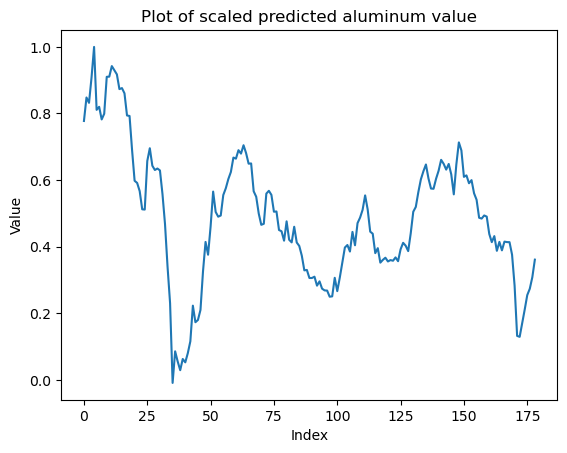

In [69]:
preds = get_predictions(lstm_model, scaler, joined_data)
type(preds)
numpy_data = preds.detach().numpy()

# Plot the NumPy array using matplotlib
plt.plot(numpy_data)
plt.title('Plot of scaled predicted aluminum value')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

### Prophet Model

In [70]:
from prophet import Prophet

In [71]:
joined_data

,inflation,st_interest,lt_interest,PPP,alu_value,Geschäftslage,electricity_price,crude_oil,Year,Month
0,2.888205,3.24079,3.881354,0.740847,1964.83,91.8,65.2669,62.811818,2006,1
1,2.888205,3.24079,3.881354,0.740847,2056.74,93.2,68.5171,62.811818,2006,2
2,2.888205,3.24079,3.881354,0.740847,2021.01,94.2,62.4558,62.811818,2006,3
3,2.888205,3.24079,3.881354,0.740847,2136.25,94.3,43.2432,62.811818,2006,4
4,2.888205,3.24079,3.881354,0.740847,2240.95,97.1,33.8149,62.811818,2006,5
...,...,...,...,...,...,...,...,...,...,...
175,0.404157,-0.42515,0.083638,0.644620,1468.79,87.7,34.5799,42.438462,2020,8
176,0.404157,-0.42515,0.083638,0.644620,1479.32,89.5,43.6161,42.438462,2020,9
177,0.404157,-0.42515,0.083638,0.644620,1533.99,90.5,33.568,42.438462,2020,10
178,0.404157,-0.42515,0.083638,0.644620,1635.95,90.2,38.5392,42.438462,2020,11


In [72]:
# prepare forecast of regressors(financial data + Energy data)
features = []
for column in joined_data.columns:
    features.append(column)
    
data = joined_data[features]
data.rename(columns={'Year': 'year', 'Month': 'month'}, inplace=True)

# Create a new DataFrame with 'ds' as the date column
data['day'] = 1
data['ds'] = pd.to_datetime(data[['year', 'month', 'day']])
data.drop(['year', 'month', 'day'], axis=1, inplace = True)

regressors = joined_data.drop(['alu_value','Year','Month'], axis = 1).columns.tolist()
combined_predictions = pd.DataFrame()

# Loop through each regressor and fit a model
for regressor in regressors:
    data_regressor = data[['ds', regressor]]
    data_regressor.rename(columns={regressor: 'y'}, inplace = True)
    
    # Instantiate and fit the Prophet model
    model = Prophet()
    model.fit(data_regressor)
    future = model.make_future_dataframe(periods= 12 * 2, freq = 'M')

    # Make predictions for the future period
    forecast = model.predict(future)
    combined_predictions[regressor] = forecast['yhat']

combined_predictions.insert(0, 'ds', future['ds'])
combined_predictions

WARNING - (py.warnings._showwarnmsg) - C:\Users\mahmo\AppData\Local\Temp\ipykernel_24452\321389887.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_regressor.rename(columns={regressor: 'y'}, inplace = True)

19:42:39 - cmdstanpy - INFO - Chain [1] start processing
19:42:39 - cmdstanpy - INFO - Chain [1] done processing
WARNING - (py.warnings._showwarnmsg) - C:\Users\mahmo\AppData\Local\Temp\ipykernel_24452\321389887.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_regressor.rename(columns={regressor: 'y'}, inplace = True)

19:42:39 - cmdstanpy - INFO - Chain [1] start processing
19:42:39 - cmdstanpy -

,ds,inflation,st_interest,lt_interest,PPP,Geschäftslage,electricity_price,crude_oil
0,2006-01-01,3.065352,4.323244,3.887867,0.738976,97.664678,53.884044,70.021378
1,2006-02-01,3.071306,4.308993,3.936894,0.739606,97.339487,53.218398,70.464351
2,2006-03-01,3.076542,4.311996,3.983843,0.740035,96.713559,48.078446,70.869354
3,2006-04-01,3.075606,4.311453,4.025664,0.740349,97.150827,47.282121,71.333224
4,2006-05-01,3.077023,4.311617,4.072240,0.740694,96.889123,45.691919,71.786851
...,...,...,...,...,...,...,...,...
199,2022-07-31,0.098359,-0.876399,-0.484619,0.628245,86.665472,27.627637,32.175147
200,2022-08-31,0.098186,-0.917745,-0.500381,0.628775,86.161224,32.153324,31.736629
201,2022-09-30,0.101097,-1.014892,-0.556377,0.628602,86.041158,33.781414,31.323398
202,2022-10-31,0.095452,-1.101439,-0.628199,0.627963,87.170994,34.703617,30.845844


## Methods to get predictions of material trends

In [73]:
# Method to train required model on trend plus financials forecast regressors
def train_model(train_data, forecasting_period, material_trend):
    data = train_data.copy()
    data.rename(columns={material_trend: 'y'}, inplace=True)
    # Instantiate and fit the Prophet model with additional regressors
    model = Prophet()
    #regressors = data.drop(['ds','y','PPP','st_interest','lt_interest','crude_oil', 'electricity_price','labor_cost', 'Geschäftslage'], axis = 1).columns.tolist()
    #for regressor in regressors:
    #    model.add_regressor(regressor)
    model.fit(data)
    return model

In [74]:
def predict_material_trend(combined_data, data, material, period_of_time):
    model = train_model(data, period_of_time, material)
    forecast = model.predict(combined_predictions)
    return forecast, model

19:42:41 - cmdstanpy - INFO - Chain [1] start processing
19:42:41 - cmdstanpy - INFO - Chain [1] done processing


Text(74.22222222222221, 0.5, 'Value')

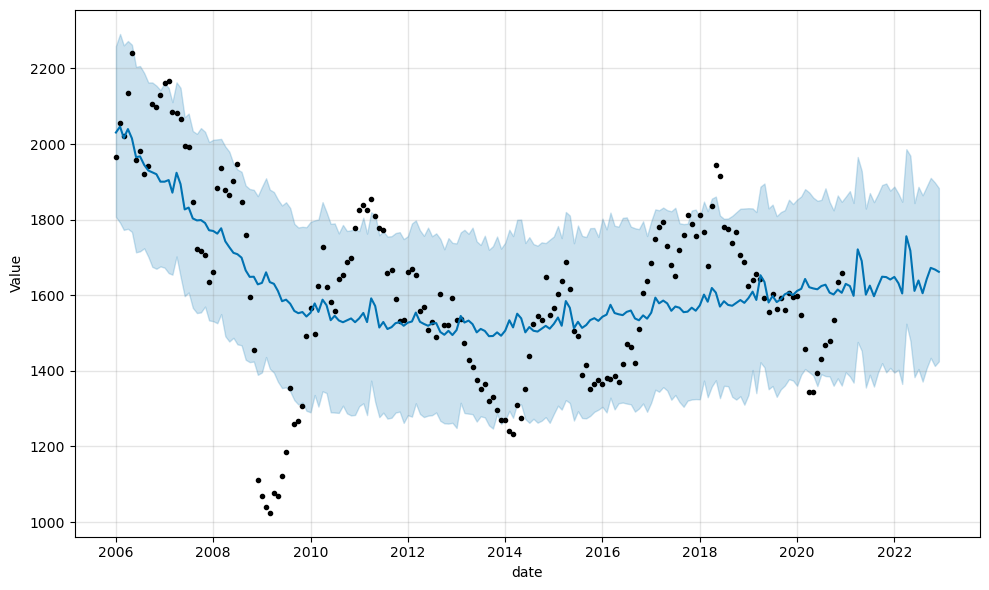

In [75]:
forecast, model = predict_material_trend(combined_predictions, data, 'alu_value', 2)
fig1 = model.plot(forecast)
ax = fig1.gca()  # Get the current Axes
ax.set_xlabel('date')  # Set the x-axis label
ax.set_ylabel('Value')  # Set the y-axis label

In [76]:
#getting thesubsets of the forecasted 2 years for calculating testing MSE
forecast_future_values = forecast[(forecast['ds'] >= '2021-01')].reset_index(drop=True)
aluminum_test_data = aluminum_cleaned[(aluminum_cleaned['date'] >= '2021-01') & (aluminum_cleaned['date'] <= '2022-11') ].reset_index(drop=True)

In [77]:
mse = mean_squared_error(forecast_future_values['yhat'], aluminum_test_data['alu_value'])
rmse = np.sqrt(mse)
rmse

772.1357217397722

In [78]:
def save_model(model_proph, name):
    #save model pickle file
    model_file_name = name
    with open(model_file_name, 'wb') as file:
        pickle.dump(model_proph, file)

# Neural Prophet

In [79]:
from neuralprophet import set_log_level
set_log_level("ERROR")

In [80]:
# Get single feature prediction for every feature to be used as regressors:
# prepare forecast of regressors
features = []
for column in joined_data.columns:
    features.append(column)
    
data = joined_data[features]
data.rename(columns={'Year': 'year', 'Month': 'month'}, inplace=True)

# Create a new DataFrame with 'ds' as the date column
data['day'] = 1
data['ds'] = pd.to_datetime(data[['year', 'month', 'day']])
data.drop(['year', 'month', 'day'], axis=1, inplace = True)
data.rename(columns={'alu_value': 'y'}, inplace=True)

regressors = joined_data.drop(['alu_value','Year','Month'], axis = 1).columns.tolist()
neural_combined_predictions = pd.DataFrame()

# Loop through each regressor and fit a model
for regressor in regressors:
    data_regressor = data[['ds', regressor]]
    data_regressor.rename(columns={regressor: 'y'}, inplace = True)
    
    # Instantiate and fit the Prophet model
    model = NeuralProphet()
    model.fit(data_regressor)
    future = model.make_future_dataframe(data_regressor, periods= 12 * 2)

    # Make predictions for the future period
    forecast = model.predict(future)
    neural_combined_predictions[regressor] = forecast['yhat1']

neural_combined_predictions.insert(0, 'ds', future['ds'])
neural_combined_predictions

WARNING - (py.warnings._showwarnmsg) - C:\Users\mahmo\AppData\Local\Temp\ipykernel_24452\2367745894.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_regressor.rename(columns={regressor: 'y'}, inplace = True)



Finding best initial lr:   0%|          | 0/211 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 12it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mahmo\AppData\Local\Temp\ipykernel_24452\2367745894.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_regressor.rename(columns={regressor: 'y'}, inplace = True)



Finding best initial lr:   0%|          | 0/211 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 12it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mahmo\AppData\Local\Temp\ipykernel_24452\2367745894.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_regressor.rename(columns={regressor: 'y'}, inplace = True)



Finding best initial lr:   0%|          | 0/211 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 12it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mahmo\AppData\Local\Temp\ipykernel_24452\2367745894.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_regressor.rename(columns={regressor: 'y'}, inplace = True)



Finding best initial lr:   0%|          | 0/211 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 12it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mahmo\AppData\Local\Temp\ipykernel_24452\2367745894.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_regressor.rename(columns={regressor: 'y'}, inplace = True)



Finding best initial lr:   0%|          | 0/211 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 12it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mahmo\AppData\Local\Temp\ipykernel_24452\2367745894.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_regressor.rename(columns={regressor: 'y'}, inplace = True)



Finding best initial lr:   0%|          | 0/211 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 12it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\mahmo\AppData\Local\Temp\ipykernel_24452\2367745894.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_regressor.rename(columns={regressor: 'y'}, inplace = True)



Finding best initial lr:   0%|          | 0/211 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 12it [00:00, ?it/s]

,ds,inflation,st_interest,lt_interest,PPP,Geschäftslage,electricity_price,crude_oil
0,2021-01-01,0.729413,-0.534001,-0.202997,0.637630,91.729782,35.938633,53.417923
1,2021-02-01,0.770179,-0.520322,-0.196926,0.637994,91.040207,35.508488,53.355347
2,2021-03-01,0.718893,-0.508748,-0.199475,0.637854,90.611824,30.640690,53.288246
3,2021-04-01,0.734471,-0.482623,-0.198263,0.637897,89.855606,29.789146,53.431179
4,2021-05-01,0.696867,-0.477012,-0.211499,0.637772,89.333565,28.273190,53.589615
5,2021-06-01,0.721362,-0.451113,-0.214431,0.637894,88.963715,31.783535,53.081131
6,2021-07-01,0.688922,-0.443011,-0.218441,0.637939,89.069565,35.242928,53.516911
7,2021-08-01,0.739704,-0.417043,-0.211460,0.638018,88.676437,34.224449,53.872169
8,2021-09-01,0.713108,-0.398330,-0.220639,0.637911,88.669220,37.762753,53.814507
9,2021-10-01,0.707910,-0.396401,-0.222890,0.638044,88.231468,39.137169,54.054504


In [82]:
data.rename(columns={'alu_value': 'y'}, inplace=True)
#df['Geschäftslage'] = df['Geschäftslage'].astype(float)
# Initialize NeuralProphet model
neural_model_prophet = NeuralProphet(
    n_changepoints=10,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    n_lags=3,  # Autogression
)

regressors = data.drop(['ds','y'], axis=1).columns.tolist()
# for regressor in regressors:
#    neural_model_prophet.add_future_regressor(regressor)

metrics = neural_model_prophet.fit(data[['ds','y']])

Finding best initial lr:   0%|          | 0/211 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [83]:
combined_df = pd.concat([data, neural_combined_predictions], ignore_index=True)
combined_df

,inflation,st_interest,lt_interest,PPP,y,Geschäftslage,electricity_price,crude_oil,ds
0,2.888205,3.240790,3.881354,0.740847,1964.83,91.8,65.2669,62.811818,2006-01-01
1,2.888205,3.240790,3.881354,0.740847,2056.74,93.2,68.5171,62.811818,2006-02-01
2,2.888205,3.240790,3.881354,0.740847,2021.01,94.2,62.4558,62.811818,2006-03-01
3,2.888205,3.240790,3.881354,0.740847,2136.25,94.3,43.2432,62.811818,2006-04-01
4,2.888205,3.240790,3.881354,0.740847,2240.95,97.1,33.8149,62.811818,2006-05-01
...,...,...,...,...,...,...,...,...,...
199,0.518946,-0.457568,-0.585358,0.631386,NaN,84.644356,33.709854,53.205006,2022-08-01
200,0.518010,-0.425257,-0.588016,0.631367,NaN,84.563225,37.626804,53.141346,2022-09-01
201,0.488059,-0.436314,-0.596370,0.631419,NaN,84.200279,38.627552,53.384800,2022-10-01
202,0.479926,-0.410013,-0.591000,0.631494,NaN,83.950333,39.866756,53.613113,2022-11-01


In [84]:
# Predict
future = neural_model_prophet.make_future_dataframe(data[['ds','y']], periods=24, n_historic_predictions=len(data[['ds','y']]))
forecast = neural_model_prophet.predict(future)
neural_model_prophet.plot(forecast)

Predicting: 12it [00:00, ?it/s]

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': 'rgba(45, 146, 255, 1.0)', 'width': 2},
              'mode': 'lines',
              'name': 'yhat1',
              'type': 'scatter',
              'uid': 'ddf0ebfe-e9ec-4148-9283-f7d75c74d919',
              'x': array([datetime.datetime(2006, 1, 1, 0, 0),
                          datetime.datetime(2006, 2, 1, 0, 0),
                          datetime.datetime(2006, 3, 1, 0, 0),
                          datetime.datetime(2006, 4, 1, 0, 0),
                          datetime.datetime(2006, 5, 1, 0, 0),
                          datetime.datetime(2006, 6, 1, 0, 0),
                          datetime.datetime(2006, 7, 1, 0, 0),
                          datetime.datetime(2006, 8, 1, 0, 0),
                          datetime.datetime(2006, 9, 1, 0, 0),
                          datetime.datetime(2006, 10, 1, 0, 0),
                          datetime.datetime(2006, 11, 1, 0, 0),
                       

In [86]:
# Predict with no autoregression on the original aluminum dataframe
aluminum_cleaned.rename(columns= {'date':'ds', 'alu_value':'y'}, inplace= True)
aluminum_cleaned['ds'] = pd.to_datetime(aluminum_cleaned['ds'].astype(str), format='%Y-%m')
# crop aluminum df
aluminum_cropped = aluminum_cleaned[(aluminum_cleaned['ds'] <= '2023-1') ].reset_index(drop=True)
aluminum_cropped.to_csv('data/aluminum.csv', index=False)
aluminum_cropped

,ds,y
0,2003-11-01,1289.28
1,2003-12-01,1265.87
2,2004-01-01,1273.77
3,2004-02-01,1333.03
4,2004-03-01,1350.62
...,...,...
226,2022-09-01,2247.16
227,2022-10-01,2294.28
228,2022-11-01,2309.74
229,2022-12-01,2271.02


In [87]:
neural_model_prophet = NeuralProphet(
    n_changepoints=5,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
)
metrics = neural_model_prophet.fit(aluminum_cropped)
save_model(neural_model_prophet, 'Aluminum_prophet.pkl')
future = neural_model_prophet.make_future_dataframe(aluminum_cropped, periods=24, n_historic_predictions= True)
forecast = neural_model_prophet.predict(future)
neural_model_prophet.plot(forecast)

Finding best initial lr:   0%|          | 0/212 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': 'rgba(45, 146, 255, 1.0)', 'width': 2},
              'mode': 'lines',
              'name': 'yhat1',
              'type': 'scatter',
              'uid': '81cf0f3f-1ea0-481b-967f-44b5835165e1',
              'x': array([datetime.datetime(2003, 11, 1, 0, 0),
                          datetime.datetime(2003, 12, 1, 0, 0),
                          datetime.datetime(2004, 1, 1, 0, 0), ...,
                          datetime.datetime(2024, 11, 1, 0, 0),
                          datetime.datetime(2024, 12, 1, 0, 0),
                          datetime.datetime(2025, 1, 1, 0, 0)], dtype=object),
              'y': array([1164.15454102, 1161.81494141, 1230.29663086, ..., 2535.85693359,
                          2515.92089844, 2554.63964844])},
             {'marker': {'color': 'black', 'size': 4},
              'mode': 'markers',
              'name': 'Actual',
              'type': 'scatter',
            

## ST37 Prediction

In [88]:
low_carbon.rename(columns={"PCU33211133211111": "y", "DATE" : "ds"}, inplace = True)
low_carbon['y'] = pd.to_numeric(low_carbon['y'], errors='coerce')
low_carbon["y"] = low_carbon["y"].astype('float')
low_carbon.interpolate('ffill', inplace=True)
low_carbon['ds'] = pd.to_datetime(low_carbon['ds'].astype(str), format='%Y-%m')

# crop the dataframe 
low_carbon_cropped = low_carbon[(low_carbon['ds'] <= '2023-1') ].reset_index(drop=True)
#save the dataframe
low_carbon_cropped.to_csv('data/st37.csv', index=False)
low_carbon_cropped

,ds,y
0,1983-12-01,100.000
1,1984-01-01,100.300
2,1984-02-01,100.300
3,1984-03-01,100.300
4,1984-04-01,100.400
...,...,...
465,2022-09-01,206.518
466,2022-10-01,203.912
467,2022-11-01,202.934
468,2022-12-01,195.142


In [89]:
low_carbon_prophet = NeuralProphet(
    n_changepoints=10,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
)
metrics = low_carbon_prophet.fit(low_carbon_cropped)
save_model(low_carbon_prophet, 'st37.pkl')

Finding best initial lr:   0%|          | 0/218 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [90]:
df_future = low_carbon_prophet.make_future_dataframe(low_carbon_cropped, periods=24, n_historic_predictions=True)

# Predict the future
forecast = low_carbon_prophet.predict(df_future)

# Visualize the forecast
low_carbon_prophet.plot(forecast)

Predicting: 30it [00:00, ?it/s]

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': 'rgba(45, 146, 255, 1.0)', 'width': 2},
              'mode': 'lines',
              'name': 'yhat1',
              'type': 'scatter',
              'uid': '0a386234-8de4-420a-97c4-3927cfa8dcd2',
              'x': array([datetime.datetime(1983, 12, 1, 0, 0),
                          datetime.datetime(1984, 1, 1, 0, 0),
                          datetime.datetime(1984, 2, 1, 0, 0), ...,
                          datetime.datetime(2024, 11, 1, 0, 0),
                          datetime.datetime(2024, 12, 1, 0, 0),
                          datetime.datetime(2025, 1, 1, 0, 0)], dtype=object),
              'y': array([ 98.59126282,  99.4105072 ,  98.23751068, ..., 176.39804077,
                          176.542099  , 176.39358521])},
             {'marker': {'color': 'black', 'size': 4},
              'mode': 'markers',
              'name': 'Actual',
              'type': 'scatter',
              'uid'

## High Copper Prediction

In [91]:
higher_copper.reset_index(inplace= True, drop = True)
higher_copper.rename(columns={'DATE': 'ds', 'higher DEL-Notiz' : 'y'}, inplace=True)
higher_copper['ds'] = pd.to_datetime(higher_copper['ds'].astype(str), format='%Y-%m')
higher_copper.to_csv('data/copper.csv', index=False)
higher_copper

,ds,y
0,2022-02-01,882.06
1,2022-01-01,878.30
2,2021-12-01,856.39
3,2021-11-01,867.10
4,2021-10-01,853.99
...,...,...
165,2008-05-01,554.52
166,2008-04-01,566.35
167,2008-03-01,558.71
168,2008-02-01,551.07


In [92]:
higher_copper_prophet = NeuralProphet()
metrics = higher_copper_prophet.fit(higher_copper)
save_model(higher_copper_prophet, 'higher_copper.pkl')

Finding best initial lr:   0%|          | 0/210 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [93]:
df_future_copper = higher_copper_prophet.make_future_dataframe(higher_copper, n_historic_predictions=True, periods=24)

# Predict the future
forecast_copper = higher_copper_prophet.predict(df_future_copper)

# Visualize the forecast
higher_copper_prophet.plot(forecast_copper)

Predicting: 11it [00:00, ?it/s]

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': 'rgba(45, 146, 255, 1.0)', 'width': 2},
              'mode': 'lines',
              'name': 'yhat1',
              'type': 'scatter',
              'uid': '2f4af800-b795-43d5-9487-ae250a510e5e',
              'x': array([datetime.datetime(2008, 1, 1, 0, 0),
                          datetime.datetime(2008, 2, 1, 0, 0),
                          datetime.datetime(2008, 3, 1, 0, 0),
                          datetime.datetime(2008, 4, 1, 0, 0),
                          datetime.datetime(2008, 5, 1, 0, 0),
                          datetime.datetime(2008, 6, 1, 0, 0),
                          datetime.datetime(2008, 7, 1, 0, 0),
                          datetime.datetime(2008, 8, 1, 0, 0),
                          datetime.datetime(2008, 9, 1, 0, 0),
                          datetime.datetime(2008, 10, 1, 0, 0),
                          datetime.datetime(2008, 11, 1, 0, 0),
                       

## Labor cost prediction

In [11]:
#labor_cost.reset_index(inplace=True)
# Rename the index column to 'ds'
#labor_cost.rename(columns={'TIME': 'ds', 'labor_cost' : 'y'}, inplace=True)
#labor_cost

,index,ds,y
0,0,2000-01-01,12.776052
1,1,2000-02-01,12.776052
2,2,2000-03-01,12.776052
3,3,2000-04-01,12.776052
4,4,2000-05-01,12.776052
...,...,...,...
272,272,2022-09-01,23.208056
273,273,2022-10-01,23.208056
274,274,2022-11-01,23.208056
275,275,2022-12-01,23.208056


In [215]:
# Interpolating labour cost into monthly values
'''''
labor_cost['ds'] = pd.to_datetime(labor_cost['ds'].astype(str), format='%Y-%m')
labor_cost.set_index('ds', inplace=True)
labor_cost['y'] = labor_cost['y'].astype(float)
labor_cost_monthly = labor_cost.resample('M').ffill().reset_index()
labor_cost_monthly['ds'] = labor_cost_monthly['ds'].dt.to_period('M')
labor_cost_monthly['ds'] = pd.to_datetime(labor_cost_monthly['ds'].astype(str), format='%Y-%m')
labor_cost_monthly.to_csv('data/labor_cost.csv', index=False)
labor_cost_monthly
'''''

,ds,y
0,2000-01-01,12.776052
1,2000-02-01,12.776052
2,2000-03-01,12.776052
3,2000-04-01,12.776052
4,2000-05-01,12.776052
...,...,...
272,2022-09-01,23.208056
273,2022-10-01,23.208056
274,2022-11-01,23.208056
275,2022-12-01,23.208056


In [94]:
labor_cost_prophet = NeuralProphet()
metrics = labor_cost_prophet.fit(labor_cost)
save_model(labor_cost_prophet, 'labor_cost.pkl')

Finding best initial lr:   0%|          | 0/214 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [95]:
df_future_labor = labor_cost_prophet.make_future_dataframe(labor_cost, n_historic_predictions=True, periods=24)

# Predict the future
forecast_labor = labor_cost_prophet.predict(df_future_labor)

# Visualize the forecast
labor_cost_prophet.plot(forecast_labor)

Predicting: 18it [00:00, ?it/s]

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': 'rgba(45, 146, 255, 1.0)', 'width': 2},
              'mode': 'lines',
              'name': 'yhat1',
              'type': 'scatter',
              'uid': '60ff549d-eca8-4ec6-b28b-37d780ea8d5a',
              'x': array([datetime.datetime(2000, 1, 1, 0, 0),
                          datetime.datetime(2000, 2, 1, 0, 0),
                          datetime.datetime(2000, 3, 1, 0, 0), ...,
                          datetime.datetime(2024, 11, 1, 0, 0),
                          datetime.datetime(2024, 12, 1, 0, 0),
                          datetime.datetime(2025, 1, 1, 0, 0)], dtype=object),
              'y': array([12.8810482 , 12.84785748, 12.82805634, ..., 24.24732971, 24.25626183,
                          24.76210403])},
             {'marker': {'color': 'black', 'size': 4},
              'mode': 'markers',
              'name': 'Actual',
              'type': 'scatter',
              'uid': '8953

# SHAP Experiment on Prophet Model

In [104]:
has_infinite_values = np.isinf(combined_predictions).any().any()

if has_infinite_values:
    print("The DataFrame contains infinite values.")
else:
    print("The DataFrame does not contain infinite values.")

The DataFrame does not contain infinite values.


In [105]:
# Calculate the index to split the DataFrame
split_index = int(0.8 * len(combined_predictions))

# Split the DataFrame into training and testing sets
combined_predictions_train = combined_predictions.iloc[:split_index]
combined_predictions_test = combined_predictions.iloc[split_index:]

# Verify the lengths of the resulting training and testing sets
print("Training set length:", len(combined_predictions_train))
print("Testing set length:", len(combined_predictions_test))

Training set length: 163
Testing set length: 41


In [106]:
import shap
def prophet_predict(passed_data):
    prophet_model = train_model(data, 2, 'alu_value')
    # Convert x into the format expected by Prophet
    forecast = prophet_model.predict(passed_data)
    return forecast['yhat'].values

In [107]:
# summarize background samples as k samples for faster compuations
background_summary = shap.sample(combined_predictions, 150)

explainer = shap.KernelExplainer(prophet_predict, background_summary, keep_index=True)
shap_values = explainer.shap_values(background_summary)

21:37:59 - cmdstanpy - INFO - Chain [1] start processing
21:37:59 - cmdstanpy - INFO - Chain [1] done processing
Using 150 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/150 [00:00<?, ?it/s]

21:37:59 - cmdstanpy - INFO - Chain [1] start processing
21:37:59 - cmdstanpy - INFO - Chain [1] done processing
21:38:00 - cmdstanpy - INFO - Chain [1] start processing
21:38:00 - cmdstanpy - INFO - Chain [1] done processing
21:38:16 - cmdstanpy - INFO - Chain [1] start processing
21:38:16 - cmdstanpy - INFO - Chain [1] done processing
21:38:16 - cmdstanpy - INFO - Chain [1] start processing
21:38:16 - cmdstanpy - INFO - Chain [1] done processing
21:38:32 - cmdstanpy - INFO - Chain [1] start processing
21:38:32 - cmdstanpy - INFO - Chain [1] done processing
21:38:32 - cmdstanpy - INFO - Chain [1] start processing
21:38:32 - cmdstanpy - INFO - Chain [1] done processing
21:38:49 - cmdstanpy - INFO - Chain [1] start processing
21:38:49 - cmdstanpy - INFO - Chain [1] done processing
21:38:49 - cmdstanpy - INFO - Chain [1] start processing
21:38:49 - cmdstanpy - INFO - Chain [1] done processing
21:39:06 - cmdstanpy - INFO - Chain [1] start processing
21:39:06 - cmdstanpy - INFO - Chain [1]

21:48:14 - cmdstanpy - INFO - Chain [1] done processing
21:48:14 - cmdstanpy - INFO - Chain [1] start processing
21:48:14 - cmdstanpy - INFO - Chain [1] done processing
21:48:31 - cmdstanpy - INFO - Chain [1] start processing
21:48:31 - cmdstanpy - INFO - Chain [1] done processing
21:48:31 - cmdstanpy - INFO - Chain [1] start processing
21:48:31 - cmdstanpy - INFO - Chain [1] done processing
21:48:47 - cmdstanpy - INFO - Chain [1] start processing
21:48:47 - cmdstanpy - INFO - Chain [1] done processing
21:48:47 - cmdstanpy - INFO - Chain [1] start processing
21:48:47 - cmdstanpy - INFO - Chain [1] done processing
21:49:04 - cmdstanpy - INFO - Chain [1] start processing
21:49:04 - cmdstanpy - INFO - Chain [1] done processing
21:49:04 - cmdstanpy - INFO - Chain [1] start processing
21:49:04 - cmdstanpy - INFO - Chain [1] done processing
21:49:21 - cmdstanpy - INFO - Chain [1] start processing
21:49:21 - cmdstanpy - INFO - Chain [1] done processing
21:49:21 - cmdstanpy - INFO - Chain [1] 

21:58:23 - cmdstanpy - INFO - Chain [1] done processing
21:58:40 - cmdstanpy - INFO - Chain [1] start processing
21:58:40 - cmdstanpy - INFO - Chain [1] done processing
21:58:40 - cmdstanpy - INFO - Chain [1] start processing
21:58:40 - cmdstanpy - INFO - Chain [1] done processing
21:58:56 - cmdstanpy - INFO - Chain [1] start processing
21:58:56 - cmdstanpy - INFO - Chain [1] done processing
21:58:56 - cmdstanpy - INFO - Chain [1] start processing
21:58:56 - cmdstanpy - INFO - Chain [1] done processing
21:59:13 - cmdstanpy - INFO - Chain [1] start processing
21:59:13 - cmdstanpy - INFO - Chain [1] done processing
21:59:13 - cmdstanpy - INFO - Chain [1] start processing
21:59:13 - cmdstanpy - INFO - Chain [1] done processing
21:59:29 - cmdstanpy - INFO - Chain [1] start processing
21:59:29 - cmdstanpy - INFO - Chain [1] done processing
21:59:29 - cmdstanpy - INFO - Chain [1] start processing
21:59:29 - cmdstanpy - INFO - Chain [1] done processing
21:59:45 - cmdstanpy - INFO - Chain [1] 

22:08:34 - cmdstanpy - INFO - Chain [1] done processing
22:08:34 - cmdstanpy - INFO - Chain [1] start processing
22:08:34 - cmdstanpy - INFO - Chain [1] done processing
22:08:50 - cmdstanpy - INFO - Chain [1] start processing
22:08:50 - cmdstanpy - INFO - Chain [1] done processing
22:08:50 - cmdstanpy - INFO - Chain [1] start processing
22:08:50 - cmdstanpy - INFO - Chain [1] done processing
22:09:07 - cmdstanpy - INFO - Chain [1] start processing
22:09:07 - cmdstanpy - INFO - Chain [1] done processing
22:09:07 - cmdstanpy - INFO - Chain [1] start processing
22:09:07 - cmdstanpy - INFO - Chain [1] done processing
22:09:23 - cmdstanpy - INFO - Chain [1] start processing
22:09:23 - cmdstanpy - INFO - Chain [1] done processing
22:09:23 - cmdstanpy - INFO - Chain [1] start processing
22:09:23 - cmdstanpy - INFO - Chain [1] done processing
22:09:40 - cmdstanpy - INFO - Chain [1] start processing
22:09:40 - cmdstanpy - INFO - Chain [1] done processing
22:09:40 - cmdstanpy - INFO - Chain [1] 

22:18:52 - cmdstanpy - INFO - Chain [1] done processing
22:19:09 - cmdstanpy - INFO - Chain [1] start processing
22:19:09 - cmdstanpy - INFO - Chain [1] done processing
22:19:09 - cmdstanpy - INFO - Chain [1] start processing
22:19:09 - cmdstanpy - INFO - Chain [1] done processing
22:19:26 - cmdstanpy - INFO - Chain [1] start processing
22:19:26 - cmdstanpy - INFO - Chain [1] done processing
22:19:26 - cmdstanpy - INFO - Chain [1] start processing
22:19:26 - cmdstanpy - INFO - Chain [1] done processing
22:19:42 - cmdstanpy - INFO - Chain [1] start processing
22:19:42 - cmdstanpy - INFO - Chain [1] done processing
22:19:43 - cmdstanpy - INFO - Chain [1] start processing
22:19:43 - cmdstanpy - INFO - Chain [1] done processing
22:19:59 - cmdstanpy - INFO - Chain [1] start processing
22:20:00 - cmdstanpy - INFO - Chain [1] done processing
22:20:00 - cmdstanpy - INFO - Chain [1] start processing
22:20:00 - cmdstanpy - INFO - Chain [1] done processing


In [110]:
shap_values

array([[ 23.061807  ,  24.57107508,  19.48491931, ...,  23.12404904,
         22.64448013,  24.44742228],
       [ -8.31034454,  -5.3739168 , -11.58616941, ...,  -7.51740959,
         -8.91604171,  -6.89898912],
       [  2.65783368,   5.12391687,  -1.22127883, ...,   3.1823596 ,
          1.93511175,   3.65378516],
       ...,
       [ -9.70633579,  -6.38011187, -12.68468305, ...,  -8.0457598 ,
         -9.22593688,  -7.90321777],
       [ -5.43896326,  -1.95184354,  -8.56111854, ...,  -4.14352747,
         -4.6582192 ,  -3.43358273],
       [ -4.23722108,  -1.37231489,  -7.79364029, ...,  -3.65267264,
         -4.91361032,  -2.85632772]])

In [114]:
combined_predictions.reset_index(inplace=True).drop('index',axis=1,inplace=True)

AttributeError: 'NoneType' object has no attribute 'drop'

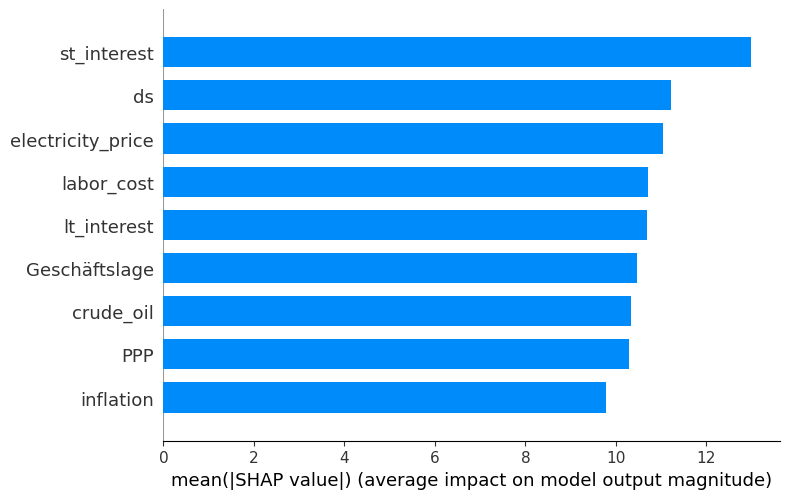

In [113]:
shap.summary_plot(shap_values, features=combined_predictions, plot_type='bar')

# Random forest as another baseline test

In [96]:
from sklearn.ensemble import RandomForestRegressor

In [97]:
# Split data into features and target
X = joined_data.drop('alu_value', axis=1)
y = joined_data['alu_value']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Predict on the test data
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 8170.773518688946


# My Fast API Demo

In [98]:
def load_model(name):
    model_path = 'models' + '/' + name + '.pkl'
    with open(model_path, 'rb') as f:
        m = pickle.load(f)
    return m

In [99]:
def porphet_predict(model_name, csv_file_name, forecasting_period = 24):
    prophet_model = load_model(model_name)
    prophet_model.restore_trainer()
    data_file_path = 'data' + '/' + csv_file_name + '.csv'
    data_file = pd.read_csv(data_file_path)
    df_future = prophet_model.make_future_dataframe(data_file, periods=forecasting_period, n_historic_predictions=True)
    # Predict the future
    forecast = prophet_model.predict(df_future)

    # get the months predicted values from yhat1
    return forecast[['ds', 'yhat1']].tail(forecasting_period), forecast[['ds', 'yhat1']]

In [100]:
def adjust_spot_price(full_projected_values, spot_price):
    # assume spot date = 1/2023
    target_date = '2023-01-01'
    target_yhat1 = full_projected_values.loc[full_projected_values['ds'] == target_date, 'yhat1'].values[0]
    full_projected_values['recalculated_yhat1'] = (full_projected_values['yhat1'] / target_yhat1) * spot_price
    # Replace the original yhat1 column with the recalculated values
    full_projected_values['yhat1'] = full_projected_values['recalculated_yhat1']

    # Drop the recalculated_yhat1 column as it's no longer needed
    full_projected_values.drop(columns=['recalculated_yhat1'], inplace=True)
    return full_projected_values

In [101]:
def product_estimate_price(args):
    total_product_values = 0

    if 'months' in args:
        forecasting_period = args['months']
    else:
        # Default period would be 24 months (2 years)
        forecasting_period = 24
        
    # Predict aluminum price if alu_weight is provided
    if 'alu_weight' in args:
        # use months as length of predicted values in the future
        alu_predicted_values, alu_full_projected_values = porphet_predict(model_name='Aluminum_prophet',
                                                                          csv_file_name='aluminum',
                                                                          forecasting_period = forecasting_period)
        alu_predicted_values.reset_index(drop= True, inplace = True)

        alu_predicted_values['yhat1'] *= args['alu_weight']
        total_product_values += alu_predicted_values['yhat1'].squeeze()
        
    # Predict st37 price if st37_weight is provided
    if 'st37_weight' in args:
        st37_predicted_values, st37_full_projected_values = porphet_predict(model_name='st37',
                                                                            csv_file_name='st37',
                                                                            forecasting_period = forecasting_period)
        st37_predicted_values.reset_index(drop= True, inplace = True)
            
        # Adjust for the spot price if it is provided
        if 'p_st37' in args:
            st37_predicted_values = adjust_spot_price(st37_full_projected_values, args['p_st37']).tail(forecasting_period)
            st37_predicted_values.reset_index(drop= True, inplace = True)
            
        st37_predicted_values['yhat1'] *= args['st37_weight']
        total_product_values += st37_predicted_values['yhat1'].squeeze()

    # Predict labour cost if labour_hours is provided
    if 'labour_hours' in args:
        print('heyy')

        labour_predicted_cost, labour_full_projected_values = porphet_predict(model_name='labor_cost',
                                                                              csv_file_name='labor_cost',
                                                                              forecasting_period = forecasting_period)
        labour_predicted_cost.reset_index(drop= True, inplace = True)

        labour_predicted_cost['yhat1'] *= args['labour_hours']
        total_product_values += labour_predicted_cost['yhat1']


    # Predict medium_carbon if labour_hours is provided
    if 'medium_carbon' in args:
        medium_carbon_predicted_cost, medium_carbon_full_projected_values = porphet_predict(model_name='medium_carbon',
                                                                                                csv_file_name='medium_carbon',
                                                                                                forecasting_period = forecasting_period)
        medium_carbon_predicted_cost.reset_index(drop= True, inplace = True)
        
        # Adjust for the spot price if it is provided
        if 'p_medium_carbon' in args:
            medium_carbon_predicted_cost = adjust_spot_price(medium_carbon_full_projected_values,
                                                             args['p_medium_carbon']).tail(forecasting_period)
            medium_carbon_predicted_cost.reset_index(drop= True, inplace = True)
        
        medium_carbon_predicted_cost['yhat1'] *= args['medium_carbon']
        total_product_values += medium_carbon_predicted_cost['yhat1']

    # Predict high_carbon if labour_hours is provided
    if 'high_carbon' in args:
        high_carbon_predicted_cost, high_carbon_full_projected_values = porphet_predict(model_name='high_carbon',
                                                                                        csv_file_name='high_carbon',
                                                                                        forecasting_period = forecasting_period)
        high_carbon_predicted_cost.reset_index(drop= True, inplace = True)
        # Adjust for the spot price if it is provided
        if 'p_high_carbon' in args:
            high_carbon_predicted_cost = adjust_spot_price(high_carbon_full_projected_values,
                                                           args['p_high_carbon']).tail(forecasting_period)
            high_carbon_predicted_cost.reset_index(drop= True, inplace = True)
        
        high_carbon_predicted_cost['yhat1'] *= args['high_carbon']
        total_product_values += high_carbon_predicted_cost['yhat1']

    # Predict nonalloy_cast if labour_hours is provided
    if 'nonalloy_cast' in args:
        nonalloy_cast_predicted_cost, nonalloy_full_projected_values = porphet_predict(model_name='nonalloy_cast',
                                                                                       csv_file_name='nonalloy_cast',
                                                                                       forecasting_period = forecasting_period)
        nonalloy_cast_predicted_cost.reset_index(drop= True, inplace = True)
        
        # Adjust for the spot price if it is provided
        if 'p_nonalloy_cast' in args:
            nonalloy_cast_predicted_cost = adjust_spot_price(nonalloy_full_projected_values,
                                                      args['p_nonalloy_cast']).tail(forecasting_period)
            nonalloy_cast_predicted_cost.reset_index(drop= True, inplace = True)
        
        nonalloy_cast_predicted_cost['yhat1'] *= args['nonalloy_cast']
        total_product_values += nonalloy_cast_predicted_cost['yhat1']

    # Predict grey_cast_iron if labour_hours is provided
    if 'grey_cast_iron' in args:
        grey_cast_iron_predicted_cost, grey_cast_full_projected_values = porphet_predict(model_name='grey_cast_iron',
                                                                                         csv_file_name='grey_cast_iron',
                                                                                         forecasting_period = forecasting_period)
        grey_cast_iron_predicted_cost.reset_index(drop= True, inplace = True)
        if 'p_grey_cast_iron' in args:
            grey_cast_iron_predicted_cost = adjust_spot_price(grey_cast_full_projected_values, args['p_grey_cast_iron']).tail(forecasting_period)
            grey_cast_iron_predicted_cost.reset_index(drop= True, inplace = True)
            print('hey')
        grey_cast_iron_predicted_cost['yhat1'] *= args['grey_cast_iron']
        total_product_values += grey_cast_iron_predicted_cost['yhat1']

    # Predict nodular_cast_iron if labour_hours is provided
    if 'nodular_cast_iron' in args:
        nodular_cast_iron_predicted_cost, nodular_cast_full_projected_values = porphet_predict(model_name='nodular_cast_iron',
                                                                                               csv_file_name='nodular_cast_iron',
                                                                                               forecasting_period=forecasting_period)
        nodular_cast_iron_predicted_cost.reset_index(drop= True, inplace = True)
        
        # Adjust for the spot price if it is provided
        if 'p_nodular_cast_iron' in args:
            nodular_cast_iron_predicted_cost = adjust_spot_price(nodular_cast_full_projected_values, args['p_nodular_cast_iron']).tail(forecasting_period)
            nodular_cast_iron_predicted_cost.reset_index(drop= True, inplace = True)
        
        nodular_cast_iron_predicted_cost['yhat1'] *= args['nodular_cast_iron']
        total_product_values += nodular_cast_iron_predicted_cost['yhat1']


    # Create a DataFrame with 'ds' column and 'total_product_value'
    total_product_df = pd.DataFrame({'ds': alu_predicted_values['ds'] if 'alu_predicted_values' in locals()
                                     else st37_predicted_values['ds'] if 'st37_predicted_values' in locals()
                                     else labour_predicted_cost['ds'] if 'labour_predicted_cost' in locals()
                                     else grey_cast_iron_predicted_cost['ds'] if 'grey_cast_iron_predicted_cost' in locals()
                                     else nodular_cast_iron_predicted_cost['ds'] if 'nodular_cast_iron_predicted_cost' in locals()
                                     else nonalloy_cast_predicted_cost['ds'] if 'nonalloy_cast_predicted_cost' in locals()
                                     else medium_carbon_predicted_cost['ds'] if 'medium_carbon_predicted_cost' in locals()
                                     else high_carbon_predicted_cost['ds'],
                                     'total_product_value': total_product_values})
    
    
    # Convert the 'ds' column to string format
    total_product_df['ds'] = total_product_df['ds'].dt.strftime('%Y-%m')

    # Convert the DataFrame to a dictionary format for API
    result_dict = total_product_df.to_dict(orient='records')
    return result_dict

In [105]:
def validate_arguments(args):
    # Define non-material keys
    non_material_keys = {"labour", "alu", "months", "copper"}
    
    # Collect spot price and material weight keys, excluding non-materials
    spot_price_keys = [key for key in args if key.startswith('p_') and key[2:] not in non_material_keys]
    material_keys = [key for key in args if key not in non_material_keys and not key.startswith('p_')]

    # Check if all spot prices have corresponding material weights
    for spot_price_key in spot_price_keys:
        material_key = spot_price_key[2:]  # Strip 'p_' to get the material key
        if material_key not in material_keys:
            raise HTTPException(status_code=400, detail=f"Weight for {material_key} is missing while its spot price is provided.")

    # If any material has a spot price, all others must have spot prices if they exist
    if spot_price_keys:
        for material_key in material_keys:
            if f"p_{material_key}" not in spot_price_keys and args[material_key] is not None:
                
                raise HTTPException(status_code=400, detail=f"Spot price for {material_key} is missing while other materials have spot prices.")

In [106]:
# Test the function
args = {'st37':1,'p_st37':100,'copper':21}
validate_arguments(args)
#result = product_estimate_price(args)
#result
validate_arguments(args)